In [34]:
import numpy as np
import matplotlib.pyplot as plt
import Qchains
import plotly.graph_objects as go
from scipy.optimize import curve_fit
from scipy.spatial.distance import pdist, squareform
from mpl_toolkits.mplot3d import Axes3D

## Buckminsterfullerene

#### OBS: These methods did not work for creating the buckministerfullerene. More work would have to go into it. The rescaling to length 1 of neighburing atoms ruins the symmetry of the structure. Think this is due to the structure consisting of a mix of pentagons and hexagons (though I think mathematically it should be possible to scale it so all neighbouring points are 1 unit length apart.) <br>
For this reason it hasn't been analysed. But other similar sphere structures have. 

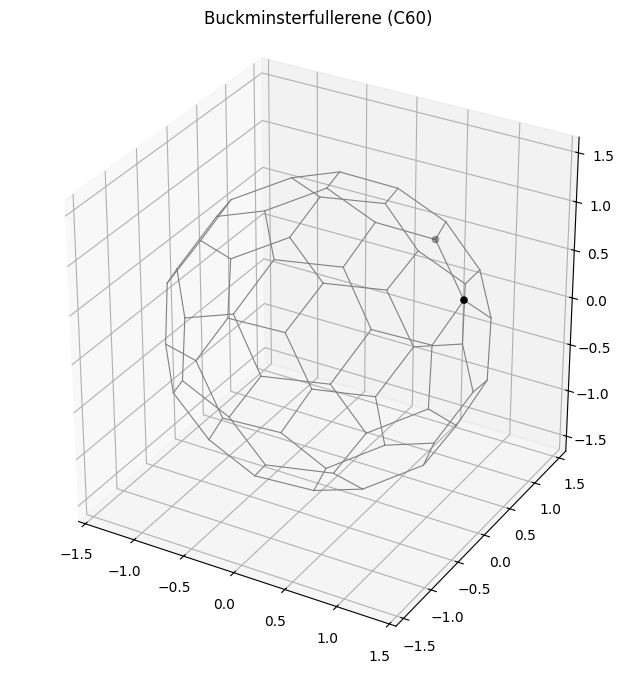

In [35]:
#Load XYZ file
def load_c60_xyz(filename="c60.xyz"):
    with open(filename, 'r') as f:
        lines = f.readlines()
    coord_lines = lines[2:]
    coords = np.array([
        list(map(float, line.strip().split()[1:4]))
        for line in coord_lines
        if len(line.strip().split()) >= 4
    ])
    return coords

#Normalize to nearest-neighbor bond = 1
def normalize_coordinates(coords):
    D = squareform(pdist(coords))
    nonzero = D[D > 0]
    hist, bins = np.histogram(nonzero, bins=100)
    shortest = bins[np.argmax(hist)]
    scale = 1 / shortest
    return coords * scale

# Plotting
def plot_c60(coords):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(coords[0:2, 0], coords[0:2, 1], coords[0:2, 2], color='black', s=20) #rn it only shows first two atoms

    # Optional: draw lines between neighbors (distance threshold)
    D = squareform(pdist(coords))
    threshold = 0.8  # Slightly larger than bond length
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            if D[i, j] < threshold:
                x = [coords[i, 0], coords[j, 0]]
                y = [coords[i, 1], coords[j, 1]]
                z = [coords[i, 2], coords[j, 2]]
                ax.plot(x, y, z, color='gray', linewidth=0.8)

    ax.set_box_aspect([1, 1, 1])
    ax.set_title("Buckminsterfullerene (C60)")
    plt.show()

# Run
coords = load_c60_xyz("c60.xyz")
coords_normalized = normalize_coordinates(coords)
plot_c60(coords_normalized)

In [36]:
np.shape(coords_normalized)

(60, 3)

In [37]:
np.linalg.norm(coords_normalized[0]-coords_normalized[1])

0.5828855972903115

In [38]:
import plotly.graph_objects as go
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Load coordinates
coords = normalize_coordinates(load_c60_xyz("c60.xyz"))


start = 0
stop = 9
# Create scatter plot of atoms
atoms = go.Scatter3d(
    x=coords[start:stop, 0],
    y=coords[start:stop, 1],
    z=coords[start:stop, 2],
    mode='markers',
    marker=dict(size=4, color='black'),
    name='Atoms'
)

# Create lines between atoms within bonding distance
D = squareform(pdist(coords))
threshold = 1.1  # bond cutoff

bond_length = 0.5
tolerance = 0.1  # allow tiny numerical error

# Only draw edges where distance ≈ bond length
edges = []
for i in range(len(coords)):
    for j in range(i + 1, len(coords)):
        dist = np.linalg.norm(coords[i] - coords[j])
        if abs(dist - bond_length) < tolerance:
            edges.append(go.Scatter3d(
                x=[coords[i, 0], coords[j, 0], None],
                y=[coords[i, 1], coords[j, 1], None],
                z=[coords[i, 2], coords[j, 2], None],
                mode='lines',
                line=dict(color='gray', width=2),
                showlegend=False
            ))


# Combine all objects
fig = go.Figure(data=[atoms] + edges)
fig.update_layout(
    title='Interactive C60 Buckminsterfullerene',
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
        aspectmode='data'
    )
)

fig.show()


In [39]:
coords[3]

array([ 1.26636158, -0.48076161,  0.49001188])

In [40]:
coords[1]

array([1.27729371, 0.07425442, 0.66929888])

In [41]:
coords[0]

array([0.91094109, 0.24832763, 1.08791552])

In [42]:
coords[5]

array([1.32459622, 0.50901698, 0.28095584])

Så 1 har 0, 3 og 5 som naboer. 

In [43]:
0.5828855972903115 * 1.7156025207154686 #Evt bare gang i distance vektoren med 1.7156025207154686

1.0

In [44]:
np.linalg.norm(coords[0] - coords[1])

0.5828855972903115

In [45]:
np.linalg.norm(coords[3] - coords[1])

0.5833576387147601

In [46]:
np.linalg.norm(coords[1]-coords[5])

0.5848643623680592

In [47]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Fit NearestNeighbors model
nbrs = NearestNeighbors(n_neighbors=4)  # include self
nbrs.fit(coords)

# Find neighbors for each point
distances, indices = nbrs.kneighbors(coords)

# Skip index 0 since it’s the point itself
nearest_3_neighbors = indices[:, 1:4]
#nearest_3_neighbors

In [48]:
def symmetric_rescale(points, nearest_3_neighbors, iterations=10, epsilon=0.1):
    points = points.copy()

    for _ in range(iterations):
        displacement = np.zeros_like(points)

        for i in range(len(points)):
            for j in nearest_3_neighbors[i]:
                if i >= j:
                    continue  # avoid double update
                direction = points[j] - points[i]
                dist = np.linalg.norm(direction)
                if dist == 0:
                    continue
                correction = epsilon * (1 - dist) * direction / dist
                displacement[i] -= correction / 2
                displacement[j] += correction / 2

        points += displacement

    return points

In [49]:
scaled_points = symmetric_rescale(coords, nearest_3_neighbors, iterations=20, epsilon=0.5)

In [50]:
start = 0
stop = 60
# Create scatter plot of atoms
atoms = go.Scatter3d(
    x=scaled_points[start:stop, 0],
    y=scaled_points[start:stop, 1],
    z=scaled_points[start:stop, 2],
    mode='markers',
    marker=dict(size=4, color='black'),
    name='Atoms'
)

# Create lines between atoms within bonding distance
D = squareform(pdist(scaled_points))
threshold = 1.1  # bond cutoff

bond_length = 1
tolerance = 0.1  # allow tiny numerical error

# Only draw edges where distance ≈ bond length
edges = []
for i in range(len(scaled_points)):
    for j in range(i + 1, len(scaled_points)):
        dist = np.linalg.norm(scaled_points[i] - scaled_points[j])
        if abs(dist - bond_length) < tolerance:
            edges.append(go.Scatter3d(
                x=[scaled_points[i, 0], scaled_points[j, 0], None],
                y=[scaled_points[i, 1], scaled_points[j, 1], None],
                z=[scaled_points[i, 2], scaled_points[j, 2], None],
                mode='lines',
                line=dict(color='gray', width=2),
                showlegend=False
            ))


# Combine all objects
fig = go.Figure(data=[atoms] + edges)
fig.update_layout(
    title='Interactive C60 Buckminsterfullerene',
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
        aspectmode='data'
    )
)

fig.show()


In [51]:
nearest_3_neighbors[0]

array([ 1, 11,  2])

In [52]:
np.linalg.norm(scaled_points[0] - scaled_points[1])

0.950669163733652

In [53]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def symmetrically_scale(points, iterations=10, epsilon=0.1):
    points = points.copy()
    N = len(points)
    nbrs = NearestNeighbors(n_neighbors=4).fit(points)  # includes self

    for _ in range(iterations):
        new_points = points.copy()

        for i in range(N):
            distances, indices = nbrs.kneighbors([points[i]], n_neighbors=4)
            neighbors = indices[0][1:]  # skip self

            for j in neighbors:
                diff = points[j] - points[i]
                dist = np.linalg.norm(diff)
                if dist == 0:
                    continue

                direction = diff / dist
                delta = epsilon * (1 - dist) * direction

                new_points[i] -= delta / 2
                new_points[j] += delta / 2

        points = new_points
        nbrs.fit(points)  # update nearest neighbors

    return points

new_coords = symmetrically_scale(coords, iterations= 10)

In [54]:
start = 0
stop = 4
# Create scatter plot of atoms
atoms = go.Scatter3d(
    x=new_coords[:, 0],
    y=new_coords[:, 1],
    z=new_coords[:, 2],
    mode='markers',
    marker=dict(size=4, color='black'),
    name='Atoms'
)

# Create lines between atoms within bonding distance
D = squareform(pdist(new_coords))
threshold = 1.1  # bond cutoff

bond_length = 1
tolerance = 0.001 # allow tiny numerical error

# Only draw edges where distance ≈ bond length
edges = []
for i in range(len(new_coords)):
    for j in range(i + 1, len(new_coords)):
        dist = np.linalg.norm(new_coords[i] - new_coords[j])
        if abs(dist - bond_length) < tolerance:
            edges.append(go.Scatter3d(
                x=[new_coords[i, 0], new_coords[j, 0], None],
                y=[new_coords[i, 1], new_coords[j, 1], None],
                z=[new_coords[i, 2], new_coords[j, 2], None],
                mode='lines',
                line=dict(color='gray', width=2),
                showlegend=False
            ))


# Combine all objects
fig = go.Figure(data=[atoms] + edges)
fig.update_layout(
    title='Interactive C60 Buckminsterfullerene',
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
        aspectmode='data'
    )
)

fig.show()


In [55]:
new_coords[3]

array([ 1.45872076, -0.54244079,  0.57390628])

In [56]:
new_coords[1]

array([1.49129103, 0.07424212, 0.77100613])

In [57]:
np.linalg.norm(new_coords[1] - new_coords[0])

0.6912480333412444

### Try another method

In [58]:
import trimesh
import numpy as np

# Create a unit icosphere (subdivision level controls density)
sphere = trimesh.creation.icosphere(subdivisions=2, radius=1.0)

# Get the vertices (points on the surface)
points = sphere.vertices

# Print as array
print(points.shape)  # (N, 3) where N depends on subdivision level


(162, 3)


In [59]:
# Create scatter plot of atoms
atoms = go.Scatter3d(
    x=points[:, 0],
    y=points[:, 1],
    z=points[:, 2],
    mode='markers',
    marker=dict(size=4, color='black'),
    name='Atoms'
)

# Create lines between atoms within bonding distance
D = squareform(pdist(points))
threshold = 1.1  # bond cutoff

bond_length = 0.5465330578253433/2
tolerance = 0.1 # allow tiny numerical error

# Only draw edges where distance ≈ bond length
edges = []
for i in range(len(points)):
    for j in range(i + 1, len(points)):
        dist = np.linalg.norm(points[i] - points[j])
        if abs(dist - bond_length) < tolerance:
            edges.append(go.Scatter3d(
                x=[points[i, 0], points[j, 0], None],
                y=[points[i, 1], points[j, 1], None],
                z=[points[i, 2], points[j, 2], None],
                mode='lines',
                line=dict(color='gray', width=2),
                showlegend=False
            ))


# Combine all objects
fig = go.Figure(data=[atoms] + edges)
fig.update_layout(
    title='Interactive C60 Buckminsterfullerene',
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
        aspectmode='data'
    )
)

fig.show()

In [60]:
np.linalg.norm(points[120]-points[137])

0.3212440712800463

In [61]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Fit NearestNeighbors model
nbrs = NearestNeighbors(n_neighbors=7)  # include self
nbrs.fit(points)

# Find neighbors for each point
distances, indices = nbrs.kneighbors(points)

# Skip index 0 since it’s the point itself
nearest_6_neighbors = indices[:, 1:7]
#nearest_3_neighbors

def symmetric_rescale(points, nearest_6_neighbors, iterations=10, epsilon=0.1):
    points = points.copy()

    for _ in range(iterations):
        displacement = np.zeros_like(points)

        for i in range(len(points)):
            for j in nearest_6_neighbors[i]:
                if i >= j:
                    continue  # avoid double update
                direction = points[j] - points[i]
                dist = np.linalg.norm(direction)
                if dist == 0:
                    continue
                correction = epsilon * (1 - dist) * direction / dist
                displacement[i] -= correction / 2
                displacement[j] += correction / 2

        points += displacement

    return points

In [62]:
scaled_sphere = symmetric_rescale(points, nearest_6_neighbors, iterations= 68, epsilon=0.05)
np.linalg.norm(scaled_sphere[120]-scaled_sphere[137])

1.0102240175189672

In [63]:
# Create scatter plot of atoms
atoms = go.Scatter3d(
    x=scaled_sphere[:, 0],
    y=scaled_sphere[:, 1],
    z=scaled_sphere[:, 2],
    mode='markers',
    marker=dict(size=4, color='black'),
    name='Atoms'
)

# Create lines between atoms within bonding distance
D = squareform(pdist(scaled_sphere))
threshold = 1.1  # bond cutoff

bond_length = 1.01022
tolerance = 0.02 # allow tiny numerical error

# Only draw edges where distance ≈ bond length
edges = []
for i in range(len(scaled_sphere)):
    for j in range(i + 1, len(scaled_sphere)):
        dist = np.linalg.norm(scaled_sphere[i] - scaled_sphere[j])
        if abs(dist - bond_length) < tolerance:
            edges.append(go.Scatter3d(
                x=[scaled_sphere[i, 0], scaled_sphere[j, 0], None],
                y=[scaled_sphere[i, 1], scaled_sphere[j, 1], None],
                z=[scaled_sphere[i, 2], scaled_sphere[j, 2], None],
                mode='lines',
                line=dict(color='gray', width=2),
                showlegend=False
            ))


# Combine all objects
fig = go.Figure(data=[atoms] + edges)
fig.update_layout(
    title='Interactive C60 Buckminsterfullerene',
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
        aspectmode='data'
    )
)

fig.show()
